# Lambda School Data Science - Survival Analysis
![My normal approach is useless here, too.](https://imgs.xkcd.com/comics/probability.png)

https://xkcd.com/881/

The aim of survival analysis is to analyze the effect of different risk factors and use them to predict the duration of time between one event ("birth") and another ("death").

# Assignment - Customer Churn

Treselle Systems, a data consulting service, [analyzed customer churn data using logistic regression](http://www.treselle.com/blog/customer-churn-logistic-regression-with-r/). For simply modeling whether or not a customer left this can work, but if we want to model the actual tenure of a customer, survival analysis is more appropriate.

The "tenure" feature represents the duration that a given customer has been with them, and "churn" represents whether or not that customer left (i.e. the "event", from a survival analysis perspective). So, any situation where churn is "no" means that a customer is still active, and so from a survival analysis perspective the observation is censored (we have their tenure up to now, but we don't know their *true* duration until event).

Your assignment is to [use their data](https://github.com/treselle-systems/customer_churn_analysis) to fit a survival model, and answer the following questions:

- What features best model customer churn?
- What would you characterize as the "warning signs" that a customer may discontinue service?
- What actions would you recommend to this business to try to improve their customer retention?

Please create at least *3* plots or visualizations to support your findings, and in general write your summary/results targeting an "interested layperson" (e.g. your hypothetical business manager) as your audience.

This means that, as is often the case in data science, there isn't a single objective right answer - your goal is to *support* your answer, whatever it is, with data and reasoning.

Good luck!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines
pd.set_option('display.max_columns', None)  # Unlimited columns

In [2]:
# Loading the data to get you started
churn_data = pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
churn_data.info()  # A lot of these are "object" - some may need to be fixed...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

## Data Cleaning

In [9]:
# Some columns we just don't need.
churn2 = churn_data.drop(columns = 'customerID')

# The two numerical columns at the end should really be numerical
churn3 = churn2
churn3['MonthlyCharges'] = pd.to_numeric(churn3['MonthlyCharges'])
churn3['TotalCharges'] = pd.to_numeric(churn3['TotalCharges'], 
                                       errors='coerce')

# There are 11 nulls in TotalCharges, which I'll replace with the mean
# value for that column
TotalCharges_mean = churn3['TotalCharges'].mean()
churn3['TotalCharges'].fillna(TotalCharges_mean, inplace=True)

# Lifelines requires numerical yes and no values.
churn4 = churn3.replace({'Yes':1, 'No':0})

In [26]:
# I'll one-hot encode all the categorical columns
numerical_columns = ['tenure','MonthlyCharges','TotalCharges','Churn']
churn5 = churn4.drop(columns=numerical_columns)
churn6 = pd.get_dummies(churn5)
churn7 = churn4[numerical_columns].join(churn6)
print(churn7.shape)
churn7.head()

(7043, 42)


,tenure,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,gender_Female,gender_Male,MultipleLines_0,MultipleLines_1,MultipleLines_No phone service,InternetService_0,InternetService_DSL,InternetService_Fiber optic,OnlineSecurity_0,OnlineSecurity_1,OnlineSecurity_No internet service,OnlineBackup_0,OnlineBackup_1,OnlineBackup_No internet service,DeviceProtection_0,DeviceProtection_1,DeviceProtection_No internet service,TechSupport_0,TechSupport_1,TechSupport_No internet service,StreamingTV_0,StreamingTV_1,StreamingTV_No internet service,StreamingMovies_0,StreamingMovies_1,StreamingMovies_No internet service,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,34,56.95,1889.50,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,45,42.30,1840.75,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0
4,2,70.70,151.65,1,0,0,0,1,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


## Snapshot of customer retention

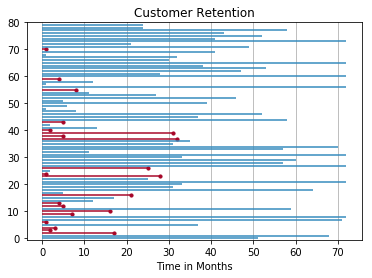

In [27]:
# I'll first plot the lifelines of a sample of 80 customers
churn_sample = churn7.sample(80)

time = churn_sample.tenure.values
event = churn_sample.Churn.values

ax = lifelines.plotting.plot_lifetimes(time, event_observed=event)
# ax.set_xlim(0, 40)
ax.grid(axis='x')
ax.set_xlabel("Time in Months")
ax.set_title("Customer Retention");
plt.plot();

This is a small sample of the customer population, showing how long customers (individual lines) have been with the company (length of lines). Red lines end when a customer is lost. Blue lines show a customer that is still with the company.

## Survival estimate curve

0    0.5
dtype: float64
Median time before losing customer: inf weeks


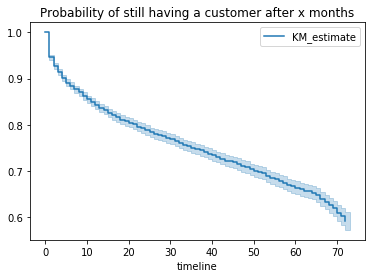

In [28]:
time = churn7.tenure.values;
event = churn7.Churn.values;

kmf = lifelines.KaplanMeierFitter();
kmf.fit(time, event_observed=event);
kmf.plot();
plt.title('Probability of still having a customer after x months');
print(f'Median time before losing customer: {kmf.median_} weeks')

### Survival Regression

In [45]:
# I use the Cox Proportional Hazards model for a survival regression
# The matrix has high collinearity, so the internet suggests 
# adding a penalizer term.  The rationale here is not entirely clear
cph = lifelines.CoxPHFitter(penalizer=0.01)
cph.fit(churn7, 'tenure', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7043
  number of events = 1869
    log-likelihood = -12659.69
  time fit was run = 2019-01-23 03:52:56 UTC

---
                                         coef  exp(coef)  se(coef)      z      p  log(p)  lower 0.95  upper 0.95     
MonthlyCharges                           0.01       1.01      0.02   0.57   0.57   -0.57       -0.03        0.06     
TotalCharges                            -0.00       1.00      0.00 -39.16 <0.005    -inf       -0.00       -0.00  ***
SeniorCitizen                            0.03       1.04      0.06   0.61   0.54   -0.61       -0.08        0.15     
Partner                                 -0.18       0.84      0.06  -3.23 <0.005   -6.71       -0.29       -0.07    *
Dependents                              -0.09       0.91      0.07  -1.31   0.19   -1.66       -0.23        0.05     
PhoneService                  

After fitting the model, the following variables have coefficients significantly different from zero: TotalCharges, Partner, and PaperlessBilling

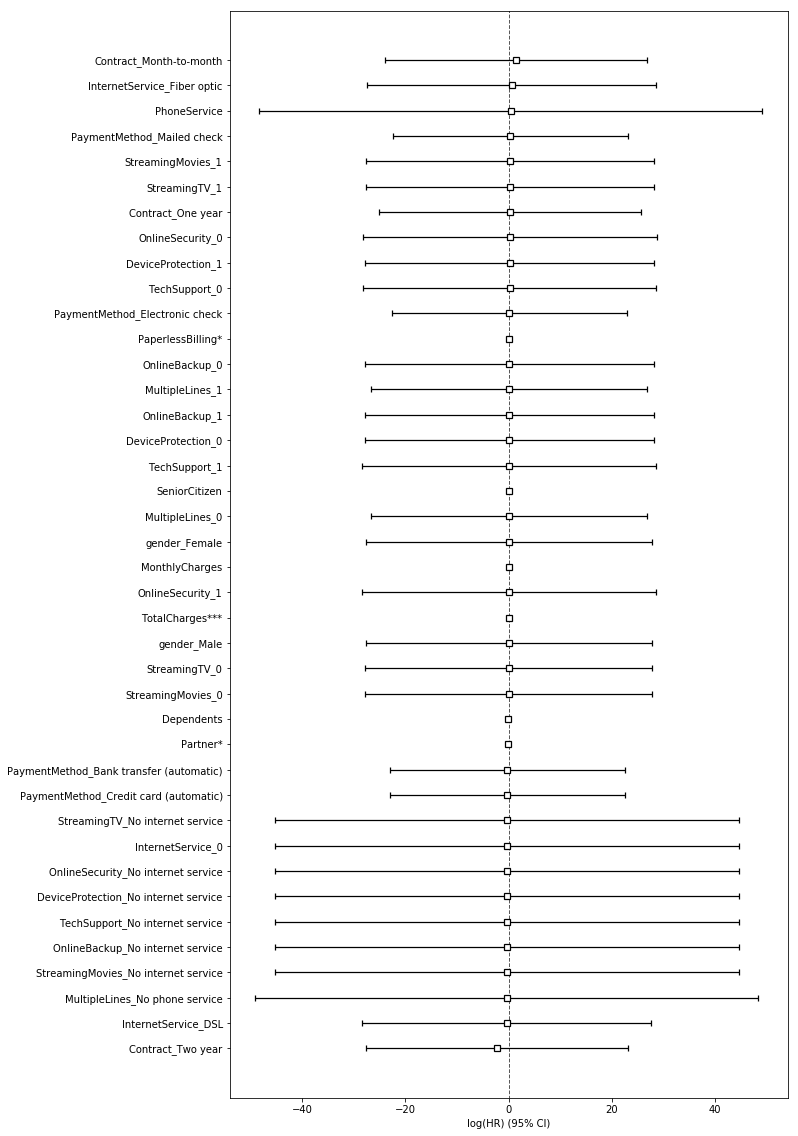

In [62]:
# I plot out the log(Hazard Ratio) for each variable, to show which variables
# are close to being significant.
fig, ax = plt.subplots(figsize=(10,20));
cph.plot(ax=ax);

## Best predictors of churn?
I will now plot predictions for several covariate groups to see if they look any different.  

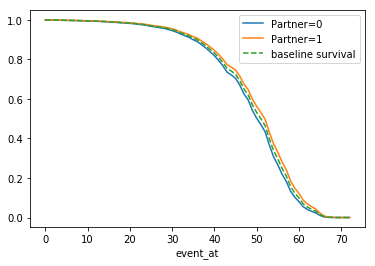

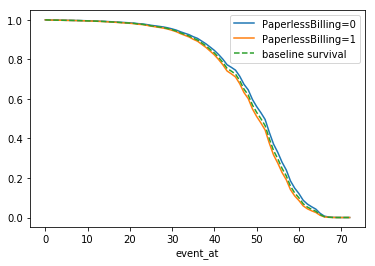

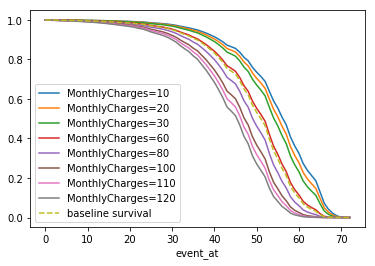

In [78]:
cph.plot_covariate_groups('Partner', [0,1]);
cph.plot_covariate_groups('PaperlessBilling', [0,1]);
cph.plot_covariate_groups('MonthlyCharges', [10,20,30,60,80,100,110,120]);

MonthlyCharges makes a big difference!!  Customers with higher monthly charges start disappearing sooner.  What about the other most significant variable in the model, TotalCharges?

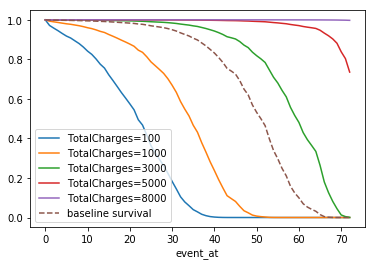

In [75]:
cph.plot_covariate_groups('TotalCharges', [100,1000,3000,5000,8000]);

This one is even starker!  But something is strange, because higher charges push a customer towards later and later disappearences.  Ah.  It must be that they are heavily correlated (because longer clients have accumulated higher TotalCharges).  Sure enough, as the following graph demonstrates:

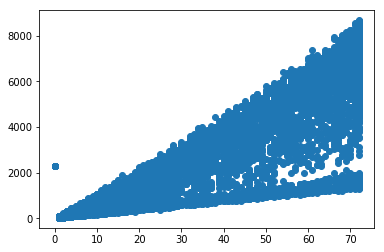

In [79]:
fig, ax = plt.subplots();
ax.scatter(churn7.tenure, churn7.TotalCharges);

In [80]:
# What if I remove that variable and run the model again?
churn8 = churn7.drop(columns='TotalCharges')

In [81]:
cph = lifelines.CoxPHFitter(penalizer=0.01)
cph.fit(churn8, 'tenure', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>
      duration col = 'tenure'
         event col = 'Churn'
number of subjects = 7043
  number of events = 1869
    log-likelihood = -13884.60
  time fit was run = 2019-01-23 05:14:37 UTC

---
                                         coef  exp(coef)  se(coef)     z      p  log(p)  lower 0.95  upper 0.95     
MonthlyCharges                          -0.01       0.99      0.02 -0.35   0.73   -0.32       -0.05        0.04     
SeniorCitizen                           -0.07       0.93      0.06 -1.26   0.21   -1.57       -0.18        0.04     
Partner                                 -0.52       0.60      0.06 -9.40 <0.005  -46.65       -0.63       -0.41  ***
Dependents                              -0.05       0.95      0.07 -0.78   0.43   -0.83       -0.19        0.08     
PhoneService                             0.02       1.02     24.86  0.00   1.00   -0.00      -48.71       48.75     
PaperlessBilling                    

Now Partner and PaperlessBilling are the best predictors!

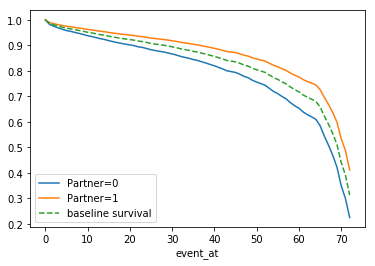

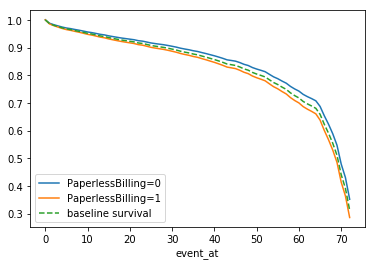

In [84]:
cph.plot_covariate_groups('Partner', [0,1]);
cph.plot_covariate_groups('PaperlessBilling', [0,1]);

### What features best model customer churn?
TotalCharges, Partner, and PaperlessBilling.  

### What would you characterize as the "warning signs" that a customer may discontinue service?
I don't know of any warning signs that change over time, but in general it's important to be wary of partnerless customers with paperless billing and high monthly charges. 

### What actions would you recommend to this business to try to improve their customer retention?
Keep track of the at-risk population and see if you can entice them to stay somehow.  I'd suggest making other changes, but I doubt that the company wants to reduce monthly payments, accept only married customers, or get rid of paperless billing.

# Resources and stretch goals

Resources:
- [Wikipedia on Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis)
- [Wikipedia on Survival functions](https://en.wikipedia.org/wiki/Survival_function)
- [Summary of survival analysis by a biostatistician](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Survival/BS704_Survival_print.html)
- [Another medical statistics article on survival analysis](https://www.sciencedirect.com/science/article/pii/S1756231716300639)
- [Survival analysis using R lecture slides](http://www.stat.columbia.edu/~madigan/W2025/notes/survival.pdf)

Stretch goals:
- Make ~5 slides that summarize and deliver your findings, as if you were to present them in a business meeting
- Revisit any of the data from the lecture material, and explore/dig deeper
- Write your own Python functions to calculate a simple hazard or survival function, and try to generate and plot data with them